<a href="https://colab.research.google.com/github/jacksonwiese/ml-bike-sales-data/blob/main/ml_bike_sales_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np #used for arrays and matrices (both high level and low level)
import pandas as pd #used for data structures and data anaylsis
import matplotlib.pyplot as plt #
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [16]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"] #removed degrees symbol from orginal csv file bc "forbidden character"
# .drop removes some of the columns
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [17]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12] #only looking at data that was collected at noon
df = df.drop(["hour"], axis=1)

In [18]:
df.head() #displays the file preview

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


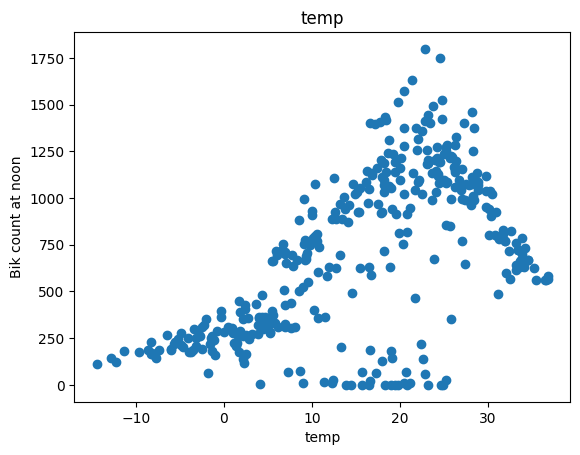

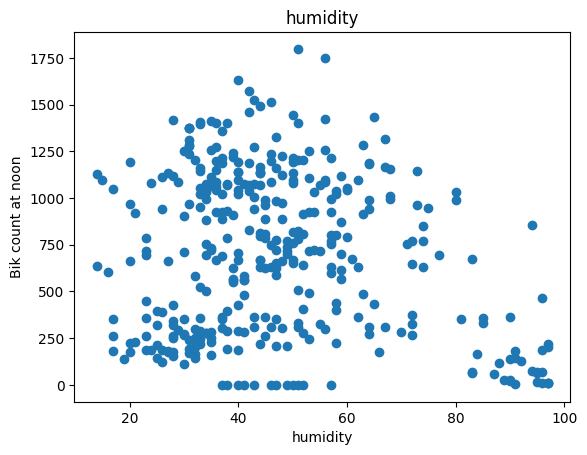

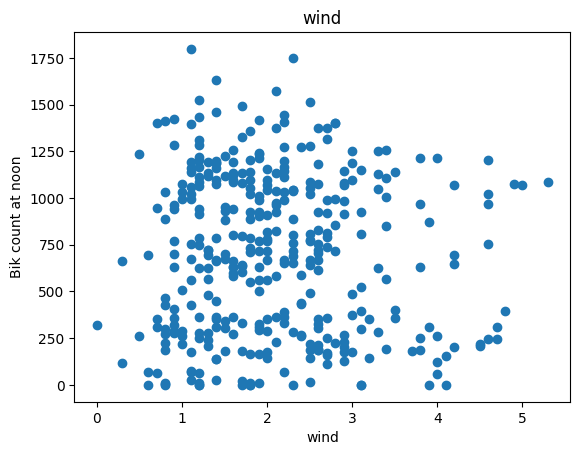

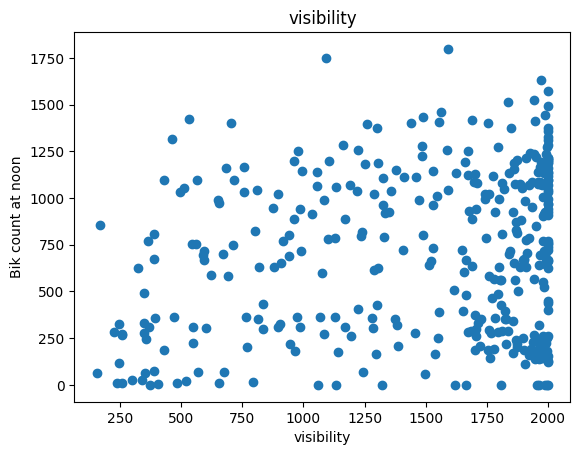

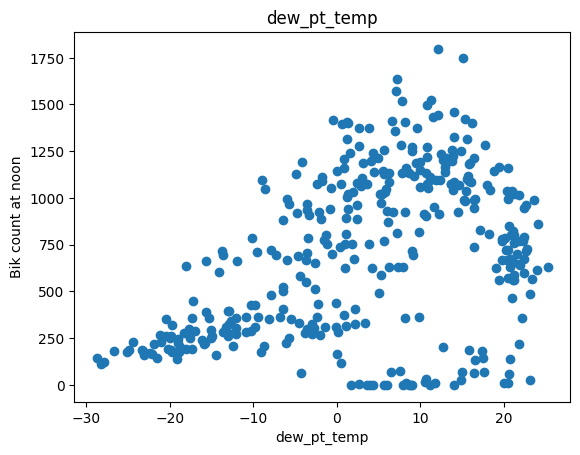

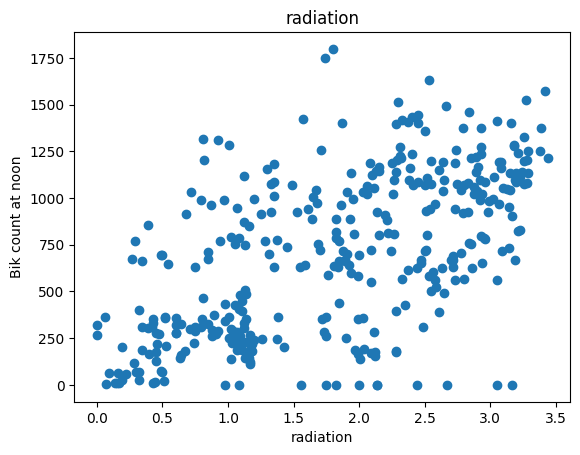

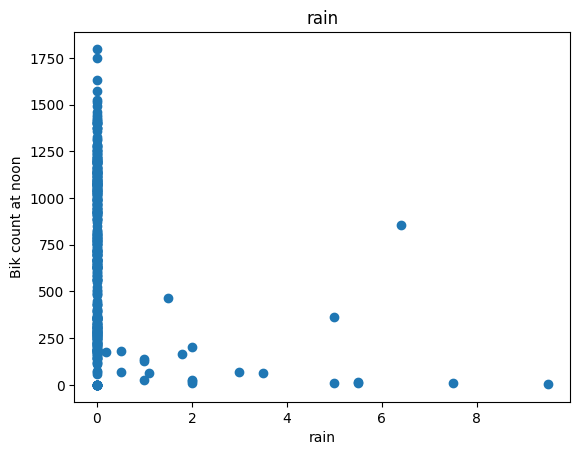

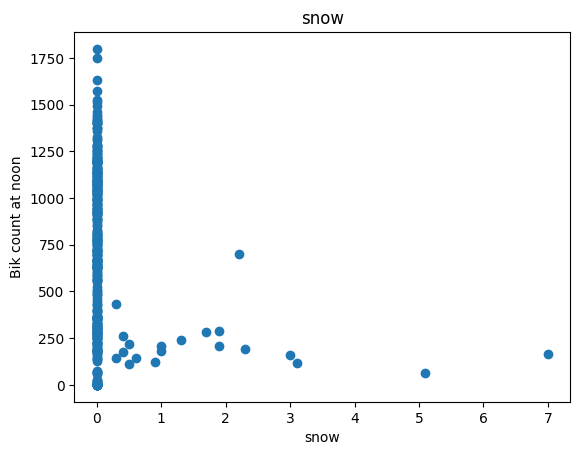

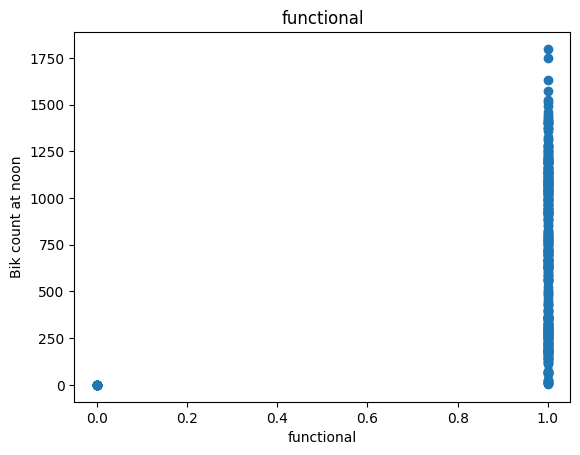

In [19]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bik count at noon")
  plt.xlabel(label)
  plt.show()

In [20]:
df = df.drop(["wind", "visibility", "functional"], axis=1)



Train / valid / test dataset

In [21]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [22]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else: 
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1,1)
    else: 
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [23]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [24]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [25]:
print(temp_reg.coef_, temp_reg.intercept_)

[[22.71487353]] [355.653236]


In [26]:
temp_reg.score(X_test_temp, y_test_temp)

0.30676365443219

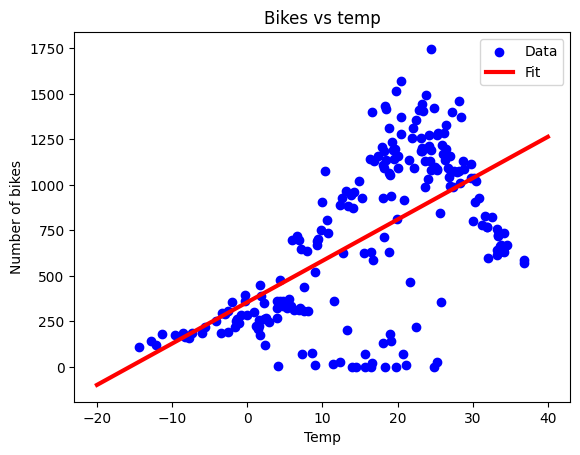

In [27]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit",  color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [28]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [29]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [30]:
all_reg.score(X_test_all, y_test_all)

0.41638698385418205

# Regression with a Neural Net

In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [32]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [33]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [34]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

In [36]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

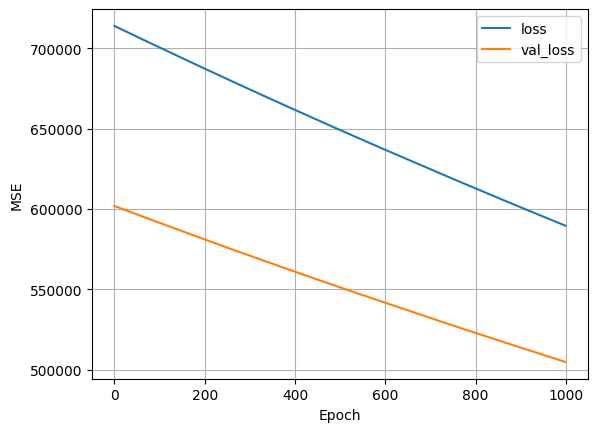

In [38]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


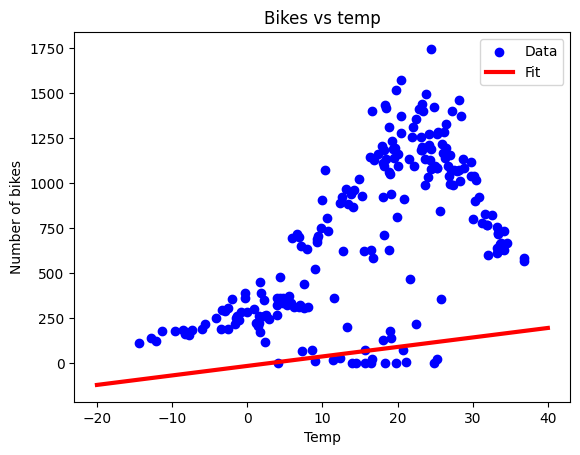

In [39]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit",  color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [50]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [51]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp), 
    verbose=0, epochs=100
)

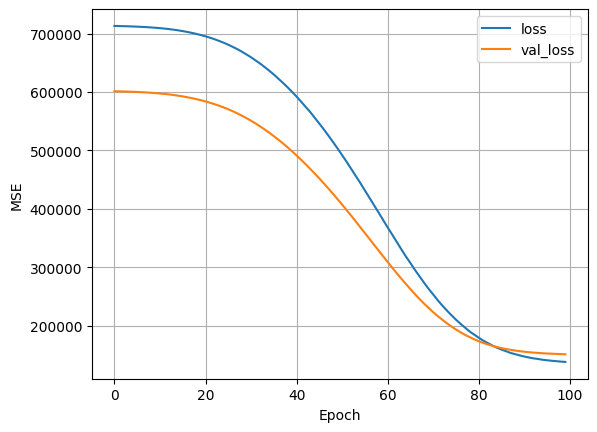

In [45]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


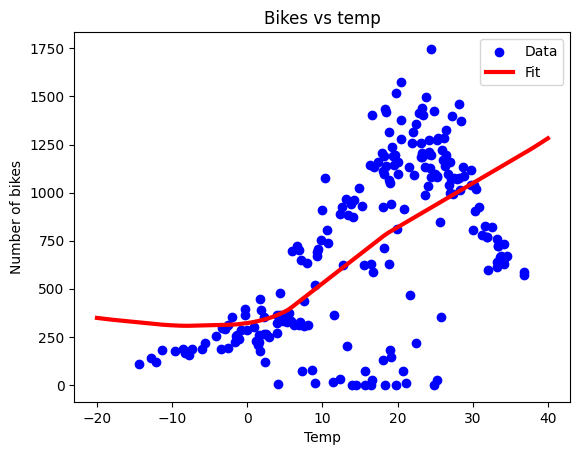

In [52]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit",  color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Network using Multiple Regression

In [64]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [65]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [66]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all), 
    verbose=0, epochs=100
)

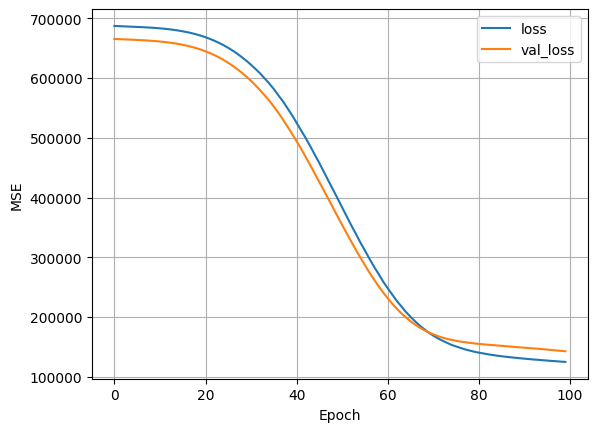

In [67]:
plot_loss(history)

In [68]:
# calculate the MSE for linear reg 
y_pred_lr = all_reg.predict(X_test_all)

# calculate the MSE for nn
y_pred_nn = nn_model.predict(X_test_all)


3/3 [==============================] - 0s 2ms/step


In [62]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [69]:
#linear regresser has smaller mean squared error than neural net
MSE(y_pred_lr, y_test_all)

93035.67751671161

In [70]:
MSE(y_pred_nn, y_test_all)

122553.88504975746

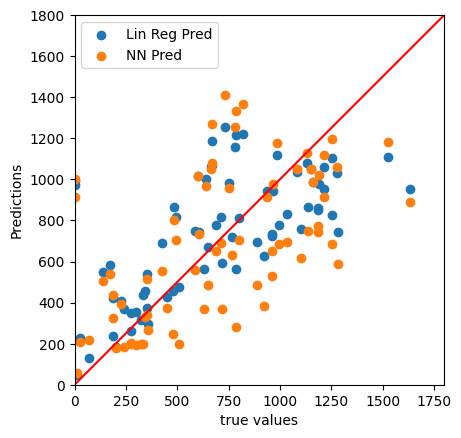

In [75]:
ax = plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Pred")
plt.scatter(y_test_all, y_pred_nn, label="NN Pred") #NN appears to under-estimate down here
plt.xlabel("true values")
plt.ylabel("Predictions")
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")